In [475]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:90% !important;}</style>'))


In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
r='03 29 41.2409'
d='-02 12 55.922'
crd = SkyCoord(r[0:2]+"h"+r[3:5]+'m'+r[6:12]+'s',d[0:3]+"d"+d[4:6]+'m'+d[7:11]+'s')
print (crd.ra.degree, crd.dec.degree)

(52.421833333333325, -2.215527777777778)


In [411]:
a= SkyCoord(245.34260464886657,38.1684351265035, unit='deg') 
a.to_string('hmsdms')


u'16h21m22.2251s +38d10m06.3665s'

jbt9b2020


(<matplotlib.image.AxesImage at 0x7f0c19276450>,
 52.42633852157279,
 -2.197376800974821,
 'ACS WFC1 F606W MJD#55838.3360')

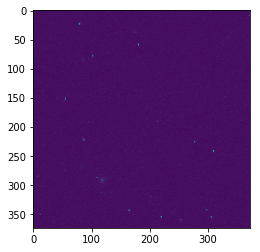

In [10]:
import subprocess
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from daomop.storage import tap_query ##_251.26625423401939_1.6683825966091756
CUTOUT_PATH ="test.fits"
ra =52.421833333333325
dec = -2.215527777777778

def get_filenames(ra, dec): #0.001
    query = '''SELECT caom2.Plane.publisherID, caom2.Plane.planeURI 
    FROM caom2.observation 
    JOIN caom2.plane ON caom2.observation.obsID = caom2.plane.obsID 
    WHERE CONTAINS( CIRCLE('ICRS',''' + str(ra) + ',' +str(dec) + ''',0.001), caom2.plane.position_bounds)=1 
    AND caom2.observation.collection = 'HST' 
    AND caom2.observation.instrument_name = 'ACS/WFC' 
    AND caom2.Plane.energy_bandpassName ='F606W'
    ''' #'F814W' F606W,F850W F475WAND   AND 
    
    out_query = tap_query(query)

    '''store the pubID and filenames'''
    success=False
    for entry in range(len(out_query["publisherID"])):#
#         if (True):
        if (("0-" in out_query["publisherID"][entry]) and ("PRODUCT" in out_query["publisherID"][entry])) :
            success=True
            start = out_query["publisherID"][entry].find('HST?') + 4 #add 4 to get to the and of the HST?
            end = out_query["publisherID"][entry].find('/j', start)
            print(out_query["publisherID"][entry][start:end])
            try:
                subprocess.check_output(["wget", "-O", CUTOUT_PATH,
                                 "http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/cutout?uri=mast:HST/product/"+
                                 str(out_query["publisherID"][entry][start:end])+"_drc.fits&cutout=Circle+ICRS+" + str(ra) + "+" +
                                 str(dec) + "+0.002"])#0.002
                break
            except:
                print('fail')
    if success==False: print('couldnt find filename')
get_filenames(ra,dec)

data, hdr = fits.getdata(CUTOUT_PATH, 1, header=True)
plt.imshow(np.log10(data+1)),hdr['CRVAL1'],hdr['CRVAL2'],hdr ['PHOTMODE']

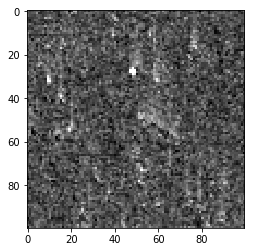

In [6]:
#view a samll window of the original image
from astropy.visualization import (ZScaleInterval, ImageNormalize)
from astropy.nddata.utils import Cutout2D

centered_cut = Cutout2D(data,(float(170), float(170)), (100, 100)).data
norm = ImageNormalize(data, interval = ZScaleInterval())
plt.imshow((centered_cut),norm=norm, cmap='gray')
# plt.imshow(np.log10(np.log10(np.log10(centered_cut+1)+1)+1))#,cmap='gray')
# plt.imshow(np.log10(np.log10(np.log10(centered_cut+1)+1)+1),cmap='gray')

In [83]:
#save the tiled image with an appropriate fits header
from astropy.wcs import WCS
wcs1 = WCS(hdr)
centered_cut = Cutout2D(data,(float(190), float(180)), (100, 100),wcs=wcs1)

hdu1 = fits.PrimaryHDU(data=centered_cut.data, header=centered_cut.wcs.to_header())
hdu1.writeto('candidate_5.fits', overwrite =True) 

In [86]:
centered_cut.data.shape

(100, 100)

In [206]:
#save as jpg
from PIL import Image
from sklearn.preprocessing import minmax_scale
centered_cut = Cutout2D(data,(float(160), float(160)), (100, 100),wcs=wcs1)
tmp_lens = centered_cut.data.reshape(-1,)                    
new = np.zeros( tmp_lens.shape,'uint8')
tmp_lens = minmax_scale(tmp_lens, feature_range = (0, 255))  
for i in range(len(tmp_lens)):
    new[i] = int(round(tmp_lens[i]))
centered_cut.data = new.reshape(centered_cut.data.shape[0],centered_cut.data.shape[1])

img = Image.fromarray(centered_cut.data)
img.save('candidtate_4_F814W.jpeg')

In [74]:
centered_cut.data

array([[ 3.,  3.,  3., ...,  1.,  2.,  2.],
       [ 5.,  3.,  4., ...,  2.,  2.,  2.],
       [ 5.,  4.,  3., ...,  2.,  2.,  2.],
       ..., 
       [ 1.,  2.,  2., ...,  2.,  2.,  2.],
       [ 1.,  3.,  3., ...,  2.,  2.,  2.],
       [ 1.,  1.,  3., ...,  3.,  2.,  2.]])

In [ ]:
#get cutouts of lenses from papers

import pandas as pd
import subprocess
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from daomop.storage import tap_query
from astropy import units as u
from astropy.coordinates import SkyCoord
CSV = '/home/toyonagar/Documents/paper_crds.csv'
CUTOUT_PATH ="/home/toyonagar/anaconda3/HST_Lens/paper_cutouts/"

def get_filenames(ra, dec,i):
    if (":" in str(ra)) or (" " in str(ra)):
        try:
            crd = SkyCoord(ra[0:2]+"h"+ra[3:5]+'m'+ra[6:10]+'s',dec[0:3]+"d"+dec[4:6]+'m'+dec[7:11]+'s')
            ra = crd.ra.degree
            dec = crd.dec.degree
        except:
            print('unable to convert crds to degree')
            print(ra)
            return 0
        
    query = '''SELECT caom2.Plane.publisherID, caom2.Plane.planeURI 
    FROM caom2.observation 
    JOIN caom2.plane ON caom2.observation.obsID = caom2.plane.obsID 
    WHERE CONTAINS( CIRCLE('ICRS',''' + str(ra) + ',' +str(dec) + ''',0.001), caom2.plane.position_bounds)=1 
    AND caom2.observation.collection = 'HST' 
    AND caom2.observation.instrument_name = 'ACS/WFC' 
    AND caom2.Plane.energy_bandpassName ='F814W'
    ''' #'F814W' F606W,F850W F475W
    try:
        out_query = tap_query(query)
    except: 
        print('tap query failed')
        print(ra,dec)
        return 0
    
    '''store the pubID and filenames'''
    success=False
    for entry in range(len(out_query["publisherID"])):
        if ("0-" in out_query["publisherID"][entry]) and ("PRODUCT" in out_query["publisherID"][entry]):
            success=True
            start = out_query["publisherID"][entry].find('HST?') + 4 #add 4 to get to the and of the HST?
            end = out_query["publisherID"][entry].find('/j', start)
            print(out_query["publisherID"][entry][start:end])
            try:
                subprocess.check_output(["wget", "-O", CUTOUT_PATH+papers['author'][i]+"_"+str(i)+'.fits',
                                 "http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/cutout?uri=mast:HST/product/"+
                                 str(out_query["publisherID"][entry][start:end])+"_drz.fits&cutout=Circle+ICRS+" + str(ra) + "+" +
                                 str(dec) + "+0.001"])
                break
            except:
                print('failed download')
    if success==False: print('couldnt find filename '+str(i))




papers = pd.read_csv(CSV, sep = ',')

for i in range(len(papers)-90):
    #for each row try to download the image
#     try:
        r = get_filenames(papers['ra'][i+90], papers['dec'][i+90],i+90)
#     except:
#         print((papers['ra'][i], papers['dec'][i],i)) 

jcow09010
j8pu51010


ERROR:root:400 Client Error: Bad Request for url: http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/tap/sync?LANG=ADQL&QUERY=SELECT+caom2.Plane.publisherID%2C+caom2.Plane.planeURI+%0A++++FROM+caom2.observation+%0A++++JOIN+caom2.plane+ON+caom2.observation.obsID+%3D+caom2.plane.obsID+%0A++++WHERE+CONTAINS%28+CIRCLE%28%27ICRS%27%2C32.014397%2C%E2%88%926.962067+%2C0.01%29%2C+caom2.plane.position_bounds%29%3D1+%0A++++AND+caom2.observation.collection+%3D+%27HST%27+%0A++++AND+caom2.observation.instrument_name+%3D+%27ACS%2FWFC%27+%0A%0A++++&REQUEST=doQuery&FORMAT=tsv
ERROR:root:400 Client Error: Bad Request for url: http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/tap/sync?LANG=ADQL&QUERY=SELECT+caom2.Plane.publisherID%2C+caom2.Plane.planeURI+%0A++++FROM+caom2.observation+%0A++++JOIN+caom2.plane+ON+caom2.observation.obsID+%3D+caom2.plane.obsID+%0A++++WHERE+CONTAINS%28+CIRCLE%28%27ICRS%27%2C32.773519%2C%E2%88%927.136335+%2C0.01%29%2C+caom2.plane.position_bounds%29%3D1+%0A++++AND+caom2.observation.collecti

tap query failed
('32.014397', '\xe2\x88\x926.962067 ')
tap query failed
('32.773519', '\xe2\x88\x927.136335 ')
tap query failed
('34.866662', '\xe2\x88\x925.488730 ')
tap query failed
('36.528578', '\xe2\x88\x929.983405 ')
tap query failed
('38.12348', '\xe2\x88\x926.227281 ')
tap query failed
('37.142005', '\xe2\x88\x925.996789 ')
tap query failed
('33.544766', '\xe2\x88\x926.093784 ')
tap query failed
('33.367565', '\xe2\x88\x926.681572 ')
tap query failed
('37.090818', '\xe2\x88\x929.645684 ')


ERROR:root:400 Client Error: Bad Request for url: http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/tap/sync?LANG=ADQL&QUERY=SELECT+caom2.Plane.publisherID%2C+caom2.Plane.planeURI+%0A++++FROM+caom2.observation+%0A++++JOIN+caom2.plane+ON+caom2.observation.obsID+%3D+caom2.plane.obsID+%0A++++WHERE+CONTAINS%28+CIRCLE%28%27ICRS%27%2C31.012133%2C%E2%88%929.745038+%2C0.01%29%2C+caom2.plane.position_bounds%29%3D1+%0A++++AND+caom2.observation.collection+%3D+%27HST%27+%0A++++AND+caom2.observation.instrument_name+%3D+%27ACS%2FWFC%27+%0A%0A++++&REQUEST=doQuery&FORMAT=tsv
ERROR:root:400 Client Error: Bad Request for url: http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/tap/sync?LANG=ADQL&QUERY=SELECT+caom2.Plane.publisherID%2C+caom2.Plane.planeURI+%0A++++FROM+caom2.observation+%0A++++JOIN+caom2.plane+ON+caom2.observation.obsID+%3D+caom2.plane.obsID+%0A++++WHERE+CONTAINS%28+CIRCLE%28%27ICRS%27%2C134.733282%2C%E2%88%921.035681+%2C0.01%29%2C+caom2.plane.position_bounds%29%3D1+%0A++++AND+caom2.observation.collect

tap query failed
('31.012133', '\xe2\x88\x929.745038 ')
tap query failed
('134.733282', '\xe2\x88\x921.035681 ')
couldnt find filename 103
couldnt find filename 104
couldnt find filename 105


ERROR:root:400 Client Error: Bad Request for url: http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/tap/sync?LANG=ADQL&QUERY=SELECT+caom2.Plane.publisherID%2C+caom2.Plane.planeURI+%0A++++FROM+caom2.observation+%0A++++JOIN+caom2.plane+ON+caom2.observation.obsID+%3D+caom2.plane.obsID+%0A++++WHERE+CONTAINS%28+CIRCLE%28%27ICRS%27%2C333.094995%2C%E2%88%920.303149+%2C0.01%29%2C+caom2.plane.position_bounds%29%3D1+%0A++++AND+caom2.observation.collection+%3D+%27HST%27+%0A++++AND+caom2.observation.instrument_name+%3D+%27ACS%2FWFC%27+%0A%0A++++&REQUEST=doQuery&FORMAT=tsv


couldnt find filename 106
tap query failed
('333.094995', '\xe2\x88\x920.303149 ')
couldnt find filename 108
j8oi03060
couldnt find filename 110
couldnt find filename 111
couldnt find filename 112
couldnt find filename 113
couldnt find filename 114
couldnt find filename 115
j8d416040
couldnt find filename 117
couldnt find filename 118
couldnt find filename 119
jbev8q010
couldnt find filename 121
j8oi12030
couldnt find filename 123
couldnt find filename 124
couldnt find filename 125
couldnt find filename 126


In [3]:
### load images from files


import os 
from astropy.io import fits 
import numpy as np 
from sklearn.preprocessing import minmax_scale
from astropy.nddata.utils import Cutout2D

PATH ="/home/toyonagar/anaconda3/HST_Lens/faure_100x100_no-norm/"
ims = np.zeros((len(os.listdir(PATH)),1,100,100))
# sp= int(input("start point"))

count=0
for filename in os.listdir(PATH): 
    try:
        pic = fits.open(PATH+filename)[0].data
        
        if pic.shape != (100, 100):    #check for cut off images
            result = np.zeros((100,100))
            result[:pic.shape[0],:pic.shape[1]] = pic
            ims[count][0] = result
            count+=1
            continue
            
        ims[count][0] = pic
        count+=1
         
    except:
        print('missed'+ str(i+sp))


